# Short Text Classification

NLP service “Bake-Off” on short-text classification of a real-world dataset.

A comparison of the short-text classification performance of a selection of commercial services, open source solutions and common research baselines.

Will cover:

* How well do the commercial NLP APIs perform on a real-world dataset?
* What are the trade-offs of various approaches?
* What should feed into a buy vs. build decision?
* A summary of lessons.

## Objective

Classify short text utterances, such as "Turn off mobile searching", by a defined set of intent categories such as "Service_Management-E_De_Activate_Roaming".

Overall goals of this research include:
* Evaluate commercial services
* Compare against baselines
* Compare against state-of-the-art
* Lessons

Specific challenges include:
* Limited context to learn semantic representations
* Limited data for sophisticated models with a large number of parameters
* Idiosyncratic text, spelling errors, abbreviations, "text speak"

The following general caveats apply:
* This paper focuses on intent classification; not entity extraction. Training both tasks together may yield an improvement.
* These results are pertinent to the specific dataset - your mileage may vary with a different dataset.
* Some methods have procedural constraints, which impact performance. A dataset tailored with these constraints in mind could improve the performance of those methods.
* The services will in all likelihood continue to evolve and improve.

## Related Work

* [Evaluating Natural Language Understanding Services for Conversational Question Answering Systems](http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf).

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report
import sys
import time
import warnings
import zipfile
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Show TensorFlow errors only
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
sys.path.append('../..')

In [5]:
from text_classification_benchmarks.data_loader import clean_data, load_data
from text_classification_benchmarks.data_loader import remove_classes_with_too_few_examples, tokenize
from text_classification_benchmarks.metrics import perf_summary, print_perf_summary
from text_classification_benchmarks.metrics import perf_by_label, print_perf_by_label
from text_classification_benchmarks.metrics import plot_confusion_matrix, print_best_worst

## About the data

The dataset was created to support a chatbot for customer self-service. It was originally created from a set of suggested intent classes and examples from the product vendor. Testing indicated that the initial dataset was oriented to a North American audience and needed to be localized.

Historical chat logs were analysed to identify frequently occurring intent classes (matched to the feasible scope), and draw examples for those classes from the chat logs.

A team was established to monitor performance in operation. One of the tasks is to identify cases where a conversation is not resolved by the chatbot and determine cause. If the cause is misunderstood intent, then the misclassified utterance is added as a new example, and the model retrained. In this way, the dataset builds up over time.

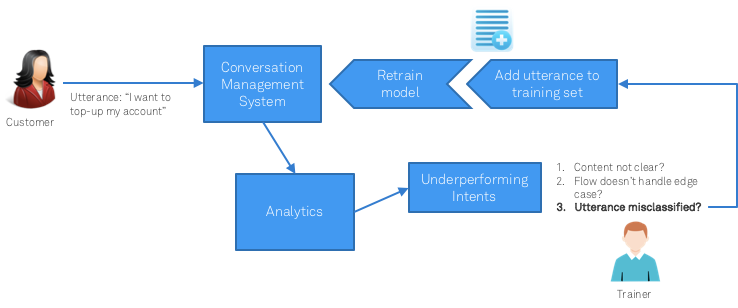

In [6]:
train_df, val_df, test_df, classes = load_data()

Lengths Train: 5696, Val: 633, Test: 703, Classes: 191


Clean data:
    
* Drop classes without an example utterance
* Replace HTML entities and common tags in text

In [7]:
train_df = tokenize(clean_data(train_df))

Length after cleaning data: 5695


In [ ]:
train_df.head()

In [9]:
sample = train_df.apply(lambda row: pd.Series([row['utterance'], classes[row['label']]], index=['utterance', 'class']), 
               axis=1)[:10]

In [10]:
sample

,utterance,class
0,Can you explain MMS charges for me while roaming?,Service_Management-E_Roaming_Inquiry
1,youre an idiott,TEMP_ChitChat-I_do_not_like_you
2,i am just making an enquiry today on the insto...,Information-E_Store_Products
3,I dnt kno wat auto pay is,Information-T_Definitions
4,I want to monthly recharge using my debit card,Payment-E_Recurring_Payment_Autopay
5,"Hi, i was trying to recharge my prepaid sim on...",Complaints-T_Troubleshooting_Credit_or_Recharge
6,Tell me about your new Telstra Tablet Plan,Service_Management-T_Price_Plan_Offers
7,"Hi Cody, I'm currently with Optus and want to ...",Sales-E_Port_In
8,"Hi, need to know if Telstra offer any phones t...",Information-E_Store_Products
9,"I'm good, how are you?",ChitChat-How_are_you


In [12]:
sample.to_csv('sample.csv', header=True, index=False)

### Remove classes with too few examples

Necessary for some models.

In [14]:
train_df = remove_classes_with_too_few_examples(train_df, min_examples=5)

Length after processing data: 5680


In [15]:
val_df = clean_data(val_df)

Length after cleaning data: 632


In [ ]:
val_df.head()

In [16]:
val_df = remove_classes_with_too_few_examples(val_df, min_examples=5)

Length after processing data: 346


In [17]:
test_df = clean_data(test_df)

Length after cleaning data: 703


In [18]:
print('Lengths after removing labels with insufficient examples Train: {}, Val: {}, Test: {}'
      .format(len(train_df), len(val_df), len(test_df)))

Lengths after removing labels with insufficient examples Train: 5680, Val: 346, Test: 703


In [19]:
trainval_df = pd.concat([train_df[['label', 'utterance']], val_df])
trainval_df = trainval_df.reset_index(drop=True)

In [20]:
len(trainval_df)

6026

In [21]:
print('Number classes after removal:', len(trainval_df.label.unique()))

Number classes after removal: 182


### Tokens per utterance

In [22]:
# Min, Max, Mean, Std Dev. of tokens per utterance
lengths = train_df['length']
print('Min token length: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(lengths.min()), int(lengths.max()), int(lengths.mean()), int(lengths.std())))

Min token length: 1, Max: 70, Mean: 12, Std: 8


In [23]:
char_lengths = train_df.utterance.apply(len)
print('Mean character length:', int(char_lengths.mean()), 'Max length:', char_lengths.max())

Mean character length: 56 Max length: 331


In [24]:
# Variance, Std. Dev. of lengths by label
lengths_by_label = train_df.groupby(['label'])['length']
print('Mean Length by Label Variance: {}, Std: {}'
      .format(int(lengths_by_label.mean().var()), int(lengths_by_label.mean().std())))

Mean Length by Label Variance: 26, Std: 5


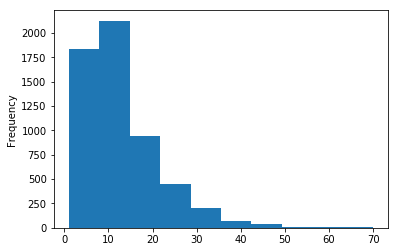

In [25]:
train_df['length'].plot.hist()

### Class Balance

Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.

In [26]:
counts_by_label = trainval_df.groupby('label').utterance.count()
print('Number Utterances by Label Min: {}, Max: {}, Mean: {}, Std: {}'
      .format(int(counts_by_label.min()), int(counts_by_label.max()), 
              int(counts_by_label.mean()), int(counts_by_label.std())))

Number Utterances by Label Min: 5, Max: 197, Mean: 33, Std: 29


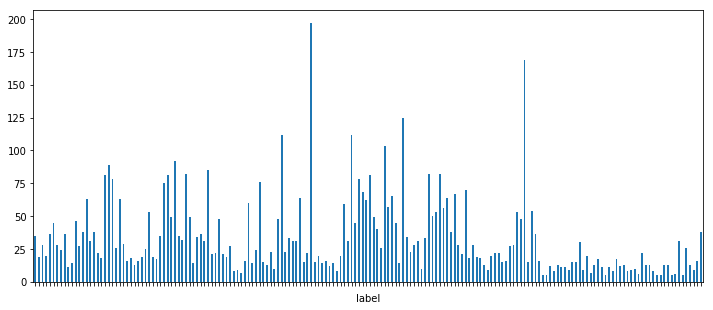

In [27]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
trainval_df.groupby('label').utterance.count().plot.bar(ylim=0)
ax.xaxis.set_major_formatter(plt.NullFormatter())  # hide labels

The dataset is imbalanced by class.

Imbalanced data typically refers to a problem with classification where the classes are not represented equally.

## Metrics

Options include:
1. Weighted average F1-score (balances precision and recall)
    * Precision - What proportion of positive identifications was actually correct? In other words, how accurate are my predictions? Low precision = too many False Positives.
    * Recall - What proportion of actual positives was identified correctly? In other words, how well did I find all the examples? Low recall = too many False Negatives.
    * Multi-class evaluation uses averages over binary evaluations, per class.
    * Weighted average = macro average weighted by support (number of true instances of each label); takes class imbalance into account.
2. Accuracy  (makes sense if your class labels are uniformly distributed)
3. ROC AUC (Area Under the Receiver Operating Characteristic Curve)
    * Larger area = better able to distinguish between True Positives and True Negatives
4. Multi-class log loss

I have selected Weighted average F1-score as the primary metric.

## Prepare Training, Validation, and Test Sets

In [28]:
columns = ['model', 'precision_weighted_avg', 'recall_weighted_avg', 'f1_weighted_avg', 
           'accuracy', 'roc_auc', 'mean_latency']

In [29]:
X_train, y_train = train_df.utterance, train_df.label
X_val, y_val = val_df.utterance, val_df.label
X_test, y_test = test_df.utterance, test_df.label
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)
n_total = n_train + n_val + n_test
print('Splits Train: {:.2f}, Val: {:.2f}, Test: {:.2f}'.format(n_train / n_total, n_val / n_total, n_test / n_total))

Splits Train: 0.84, Val: 0.05, Test: 0.10


Limit number of API calls to stay within quotas.

In [30]:
max_api_calls = 200

## Classical models

Bag-of-words features using TF-IDF.

In [31]:
from text_classification_benchmarks.tfidf_bow import generate_tfidf_features, show_relevant_terms

Combine train and val sets to generate features.

In [32]:
features, labels, tfidf, indices = generate_tfidf_features(train_df, val_df, cutoff=5, ngram_range=2)

In [33]:
print('Number Utterances: {}, Features: {}'.format(*features.shape))

Number Utterances: 6026, Features: 1407


*i* utterances represented by *j* features, representing the TF-IDF score for various unigrams and bigrams.

In [ ]:
show_relevant_terms(features, labels, tfidf, classes, every=20)

## Try multiple model types

1. Random Forest
2. Multinomimal Naive Bayes
3. Logistic Regression
4. Linear Support Vector Machine

In [34]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

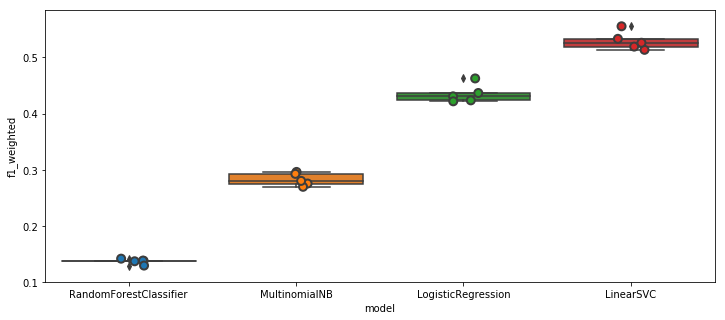

In [35]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=0),
    LinearSVC()
]

CV = 5  # number of folds in a (Stratified) KFold
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model', 'fold_idx', 'f1_weighted'])

fig = plt.figure(figsize=(12, 5))
sns.boxplot(x='model', y='f1_weighted', data=cv_df)
sns.stripplot(x='model', y='f1_weighted', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [36]:
cv_df.groupby('model').f1_weighted.mean()

model
LinearSVC                 0.529226
LogisticRegression        0.434963
MultinomialNB             0.282931
RandomForestClassifier    0.137183
Name: f1_weighted, dtype: float64

### Multinomial Naive Bayes Classifier

Naive Bayes is a family of algorithms based on applying Bayes theorem with a naive assumption, that every feature is independent of the others, in order to predict the category of a given sample. They are probabilistic classifiers, therefore will calculate the probability of each category using Bayes theorem, and the category with the highest probability will be output.

Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.

Multinomial Naive Bayes (MNB) is typically better at snippets than SVM models. Read [Baselines and Bigrams: Simple, Good Sentiment
and Topic Classification; ACL 2012](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).

In [37]:
from text_classification_benchmarks.multinomial_naive_bayes.model_setup import MultinomialNaiveBayesModel

In [38]:
model = MultinomialNaiveBayesModel(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

In [ ]:
def print_prediction(sample_idx):
    utterance = X_val[sample_idx]
    print('Utterance:', utterance)
    print('Actual:', classes[y_val[sample_idx]])
    print('Predicted:', classes[model.predict(utterance)])

In [ ]:
samples = np.random.choice(X_val.index, size=10)
for i in samples:
    print_prediction(i)
    print()

In [39]:
y_pred = [model.predict(utterance) for utterance in X_test[:max_api_calls]]

In [40]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.22
Recall (weighted avg)   : 0.28
F1 Score (weighted avg) : 0.21
Accuracy                : 0.28
ROC AUC (macro avg)     : 0.59


In [ ]:
print_perf_by_label(perf_by_label(y_test[:max_api_calls], y_pred, classes, counts_by_label), 
                    rounded=2, sort_column='f1_score')

In [ ]:
def print_classification_report(y_true, y_pred, classes):
    labels = np.unique(y_true)
    target_names = [classes[x] for x in labels]
    print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

In [ ]:
print_classification_report(y_test[:max_api_calls], y_pred, classes)

In [41]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0024


In [42]:
data = dict({'model': 'Multinomial Naive Bayes', 'mean_latency': mean_latency}, **stats)
benchmarks = pd.DataFrame(data, columns=columns, index=[0])

In [43]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.22215,0.285,0.207044,0.285,0.588689,0.0024


### Multinomial Logistic Regression

Multinomial logistic regression is an extension of the logistic regression for multiclass classification tasks.

In [44]:
import text_classification_benchmarks.logreg.model_setup as logreg

In [ ]:
# importlib.reload(logreg)

In [45]:
model = logreg.LogisticRegressionModel(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

In [46]:
y_pred = [model.predict(utterance) for utterance in X_test[:max_api_calls]]

In [47]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.46
Recall (weighted avg)   : 0.47
F1 Score (weighted avg) : 0.43
Accuracy                : 0.47
ROC AUC (macro avg)     : 0.71


In [48]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0024


In [49]:
data = dict({'model': 'Logistic Regression', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [50]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.0024
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.0024


### One-vs-rest Multilabel Classifier (Logistic Regression)

In [51]:
import nlp.multilabel_classification as logreg

In [ ]:
# importlib.reload(logreg)

In [52]:
y_train_multilabel = [[y] for y in np.concatenate([y_train, y_val])]
y_test_multilabel = [[y] for y in y_test[:max_api_calls]]
y_test_predicted_labels_bow, y_test_predicted_labels_tfidf = \
    logreg.train_and_test(x_train=np.concatenate([X_train, X_val]).tolist(), y_train=y_train_multilabel,
                          x_val=X_test[:max_api_calls].tolist(), y_val=y_test_multilabel,
                          x_test=None, classes=np.unique(np.concatenate([y_train, y_val])), dict_size=5000)

In [53]:
y_test_predicted_labels_bow = [x[0] if x else -1 for x in y_test_predicted_labels_bow]

In [54]:
stats = perf_summary(y_test[:max_api_calls], y_test_predicted_labels_bow)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.43
Recall (weighted avg)   : 0.3
F1 Score (weighted avg) : 0.34
Accuracy                : 0.3
ROC AUC (macro avg)     : 0.62


In [55]:
y_test_predicted_labels_tfidf = [x[0] if x else -1 for x in y_test_predicted_labels_tfidf]

In [56]:
stats = perf_summary(y_test[:max_api_calls], y_test_predicted_labels_tfidf)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.2
Recall (weighted avg)   : 0.11
F1 Score (weighted avg) : 0.14
Accuracy                : 0.11
ROC AUC (macro avg)     : 0.54


Some precision but too many unlabelled predictions.

**TODO:** evaluate performance against any label in multilabel prediction result.

## Linear Support Vector Classification

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
model = LinearSVC()
model.fit(features, labels)

X_test = tfidf.transform(test_df.utterance).toarray()
y_test = test_df.label
tic = time.time()
y_pred = model.predict(X_test[:max_api_calls])
toc = time.time()

In [ ]:
plot_confusion_matrix(y_test[:max_api_calls], y_pred, classes, 0, 20)

In [ ]:
stats = perf_by_label(y_test[:max_api_calls], y_pred, classes, counts_by_label)
print_perf_by_label(stats, rounded=2, sort_column='f1_score')

In [ ]:
print_classification_report(y_test[:max_api_calls], y_pred, classes)

In [ ]:
print_best_worst(stats, rounded=2, sort_column='f1_score', top_n=5, max_name_len=35)

The reported averages are a prevalence-weighted macro-average across classes (equivalent to sklearn's `precision_recall_fscore_support` with `average='weighted'`).

In [60]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.59
Recall (weighted avg)   : 0.57
F1 Score (weighted avg) : 0.56
Accuracy                : 0.57
ROC AUC (macro avg)     : 0.77


In [61]:
mean_latency = (toc - tic) / min(len(X_test), max_api_calls)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 8.587837219238282e-06


In [62]:
data = dict({'model': 'Linear SVC', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [63]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009


## Linear SVC with SMOTE Over-sampling

In [ ]:
# !conda install -y -c conda-forge imbalanced-learn

In [ ]:
# from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
# X_resampled, y_resampled = SMOTE().fit_resample(features, labels)

In [ ]:
# model_smote = LinearSVC().fit(X_resampled, y_resampled)
# tic = time.time()
# y_pred = model_smote.predict(X_test[:max_api_calls])
# toc = time.time()

In [ ]:
# stats = perf_summary(y_test[:max_api_calls], y_pred)
# print_perf_summary(stats, rounded=2)

In [ ]:
# mean_latency = (toc - tic) / min(len(X_test), max_api_calls)
# print('Mean latency (secs):', mean_latency)

In [ ]:
# data = dict({'model': 'Linear SVC with SMOTE Over-sampling', 'mean_latency': mean_latency}, **stats)
# benchmarks = benchmarks.append(data, ignore_index=True)

In [ ]:
# benchmarks

## NBSVM -  SVM with NB features

[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://www.aclweb.org/anthology/P12-2018), Sida Wang and Christopher D. Manning.

A simple but novel SVM variant using NB log-count ratios as feature values.

By combining generative and discriminative classifiers, we present a simple model variant where an SVM is built over NB log-count ratios as feature values, and show that it is a strong and robust performer.

Otherwise identical to the SVM, except we use x(k) = ˜f^(k), where ˜f(k) = ˆr ◦ ˆf(k) is the elementwise product. While this does very well for long documents, we find that an interpolation between MNB and SVM performs well for all documents and we report results using this model:

    w' = (1 − β)w¯ + βw

where w¯ = ||w||1 / |V| is the mean magnitude of w, and β ∈ [0, 1] is the interpolation parameter. This interpolation can be seen as a form of regularization: trust NB unless the SVM is very confident.

While (Ng and Jordan, 2002) showed that NB is better than SVM or Logistic Regression with few training cases, we show that MNB is also better with short documents. In contrast to their result that an SVM usually beats NB when it has more than 30–50 training cases, we show that MNB is still better on snippets even with relatively large training sets (9K cases).

In [64]:
import text_classification_benchmarks.nbsvm as nbsvm

In [ ]:
# import text_classification_benchmarks.nbsvm.model_setup

In [ ]:
# importlib.reload(text_classification_benchmarks.nbsvm.model_setup)

In [ ]:
# importlib.reload(nbsvm)

In [70]:
preds, model = nbsvm.train_and_test(trainval_df, test_df[:max_api_calls])

Vectorizing...
ngram_range: (1, 3)
Fitting...
Classifying...


In [71]:
stats = perf_summary(y_test[:max_api_calls], preds)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.56
Recall (weighted avg)   : 0.56
F1 Score (weighted avg) : 0.53
Accuracy                : 0.56
ROC AUC (macro avg)     : 0.76


In [72]:
mean_latency = round(model.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.3464


In [76]:
data = dict({'model': 'NBSVM', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [77]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400


# Open Source Options

Potential advantages:
* Data privacy
* Latency - no HTTPS calls
* Model tuning

## RASA NLU

At one point, Rasa NLU used Bag-of-Words (BoW) to find intent and Conditional Random Fields (CRF) to find entities.

RASA comes with a few NLU pipelines and models out of the box:
* A spacy-sklearn pipeline - uses pre-trained word vectors from either GloVe or fastText
* A TensorFlow pipeline that doesn't use any pretrained word vectors, but instead fits these specifically for your dataset

In [78]:
import text_classification_benchmarks.api_services.rasa_service as rasa

In [ ]:
# importlib.reload(rasa)

### Create RASA NLU Training Set

In [ ]:
# rasa.create_import_file(trainval_df, classes)

### Train TensorFlow Pipeline

In [ ]:
# !python -m rasa_nlu.train -c nlu_config.yml --data nlu.md -o models --fixed_model_name nlu --project current --verbose

### Train Spacy-sklearn Pipeline

In [ ]:
# !python -m rasa_nlu.train -c nlu_config_sklearn.yml --data nlu.md -o models --fixed_model_name nlu_sklearn --project current --verbose

### Call RASA NLU API Service

### Spacy-sklearn Pipeline

Starting with the Spacy-sklearn pipeline.

In [79]:
rasa_service = rasa.RasaService('./models/current/nlu_sklearn', classes, max_api_calls=max_api_calls, verbose=False)

In [80]:
y_pred = rasa_service.predict_batch(test_df)

In [81]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.2
Recall (weighted avg)   : 0.27
F1 Score (weighted avg) : 0.21
Accuracy                : 0.27
ROC AUC (macro avg)     : 0.6


In [82]:
mean_latency = round(rasa_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0136


In [83]:
data = dict({'model': 'RASA NLU Spacy-sklearn', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [84]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600


### TensorFlow Pipeline

In [87]:
rasa_service = rasa.RasaService('./models/current/nlu', classes, max_api_calls=max_api_calls, verbose=False)

INFO:tensorflow:Restoring parameters from ./models/current/nlu/intent_classifier_tensorflow_embedding.ckpt


In [88]:
y_pred = rasa_service.predict_batch(test_df)

In [89]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.58
Recall (weighted avg)   : 0.56
F1 Score (weighted avg) : 0.54
Accuracy                : 0.56
ROC AUC (macro avg)     : 0.77


In [90]:
mean_latency = round(rasa_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0014


In [91]:
data = dict({'model': 'RASA NLU TensorFlow', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [92]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400


## Snips NLU

Snips NLU uses logistic regression for intent classification and Conditional Random Fields (CRFs) for slot filling (entity extraction).

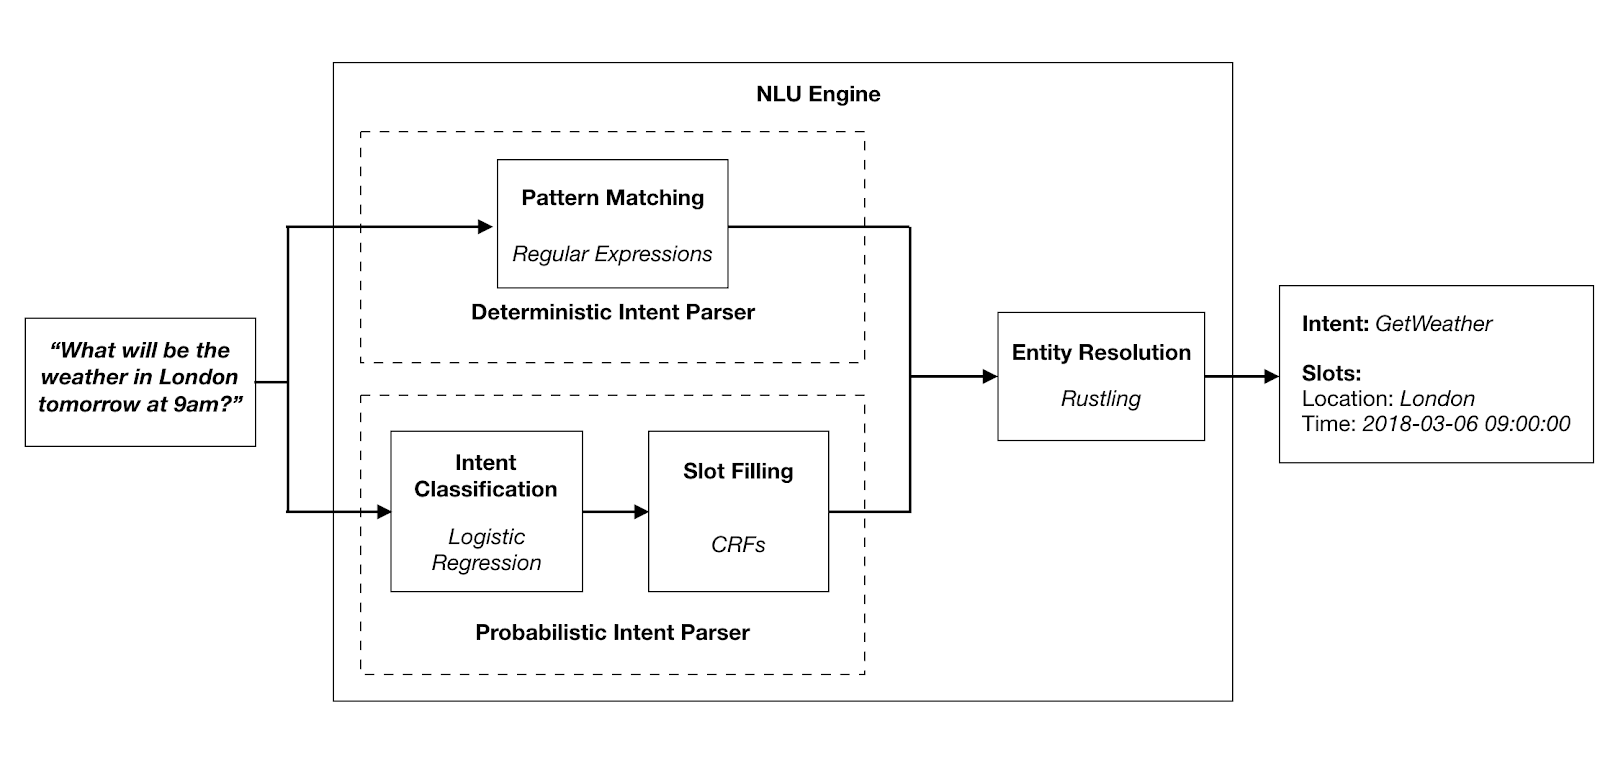

In [93]:
import text_classification_benchmarks.api_services.snips_service as snips

In [ ]:
# importlib.reload(snips)

### Create Snips NLU Training Set

In [94]:
dataset, dataset_path = snips.create_import_file(trainval_df, classes)

### Call Snips NLU API Service

In [95]:
MODEL_PATH = './snips_model'

In [96]:
snips_service = snips.SnipsService(classes, model_path=MODEL_PATH, max_api_calls=max_api_calls, verbose=False)

**Train Model**

In [ ]:
# snips_service.train_model_from_file(dataset_path)

**Save Model**

In [ ]:
# snips_service.save_model('./snips_model')

## Call Snips NLU API Service

In [ ]:
y_pred = snips_service.predict_batch(test_df)

In [98]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.59
Recall (weighted avg)   : 0.5
F1 Score (weighted avg) : 0.49
Accuracy                : 0.5
ROC AUC (macro avg)     : 0.78


In [99]:
mean_latency = round(snips_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0116


In [100]:
data = dict({'model': 'Snips NLU', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [101]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600


# Commercial Options

## IBM Watson

According to their [website](https://www.ibm.com/watson/services/natural-language-classifier/), Watson uses an ensemble of multiple support vector machines (SVMs) and a convolutional neural network (CNN).

*Max 25,000 examples per workspace.*

See [Intent Limits](https://console.bluemix.net/docs/services/assistant/intents.html#defining-intents).

In [102]:
import text_classification_benchmarks.api_services.watson_service as watson

In [ ]:
# importlib.reload(watson)

### Create Import File

In [ ]:
# watson.create_import_file(trainval_df, classes, output_path='./watson_import.csv')

### Call Watson API Service

In [ ]:
%env VAULT_TOKEN=3R5BzS8J82IpBmif06hVI72I

In [104]:
watson_service = watson.WatsonService(classes, max_api_calls=max_api_calls, verbose=False)

In [105]:
y_pred = watson_service.predict_batch(test_df)

In [106]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.68
Recall (weighted avg)   : 0.66
F1 Score (weighted avg) : 0.64
Accuracy                : 0.66
ROC AUC (macro avg)     : 0.83


In [107]:
mean_latency = round(watson_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.2696


In [108]:
data = dict({'model': 'IBM Watson', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [109]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600


## Google Dialogflow

Specific algorithms unknown.

*Maximum number of training phrases per intent is 2,000.*

In [110]:
import text_classification_benchmarks.api_services.dialogflow_service as dialogflow

In [ ]:
# importlib.reload(dialogflow)

### Create Import File

In [ ]:
# dialogflow.create_import_file(trainval_df, classes, output_path='./import')

### Call Dialogflow API Service

In [111]:
dialogflow_service = dialogflow.DialogflowService(classes, max_api_calls=max_api_calls, verbose=False)

In [112]:
y_pred = dialogflow_service.predict_batch(test_df)

In [113]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.67
Recall (weighted avg)   : 0.66
F1 Score (weighted avg) : 0.63
Accuracy                : 0.66
ROC AUC (macro avg)     : 0.81


In [114]:
mean_latency = round(dialogflow_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.6795


In [115]:
data = dict({'model': 'Google Dialogflow', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [116]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500


## Microsoft LUIS

See [Fast and easy language understanding for dialog systems with Microsoft Language Understanding Intelligent Service (LUIS), SIGDIAL 2015](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sigdial2015demo.pdf) for additional information.

Specific algorithms unknown.

*Maximum 15,000 utterances per application, limited to 500 characters per utterance.*

In [117]:
import text_classification_benchmarks.api_services.luis_service as luis

In [ ]:
# importlib.reload(luis)

### Create Training Set

In [ ]:
# luis.create_import_file(trainval_df, classes)

### Call LUIS Service

In [162]:
luis_service = luis.LuisService(classes, max_api_calls=max_api_calls, verbose=False)

In [163]:
y_pred = luis_service.predict_batch(test_df)

ERR: 'None' is not in list


In [164]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.49
Recall (weighted avg)   : 0.47
F1 Score (weighted avg) : 0.45
Accuracy                : 0.47
ROC AUC (macro avg)     : 0.71


In [165]:
mean_latency = round(luis_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.6978


In [166]:
data = dict({'model': 'Microsoft LUIS', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [167]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Amazon Lex

Only references "deep learning technologies".

Limits:
* *You can associate a maximum of 100 intents with a bot. Each intent can have up to 1,500 sample utterances.*
* Each sample utterance can be up to 200 UTF-8 characters long.
* You can use up to 200,000 characters for all intent and slot utterances in a bot.

In [168]:
import text_classification_benchmarks.api_services.lex_service as lex

In [ ]:
# importlib.reload(lex)

### Create Training Set

In [ ]:
# lex.create_import_file(pd.concat([train_df, val_df]), classes, 
#                        output_path='./lex_import', bot_name='intent_test')

### Call Lex API Service

In [169]:
lex_service = lex.LexService('intent_test', 'Prod', classes, max_api_calls=max_api_calls, verbose=False)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [171]:
# ignore test cases with untrained labels - Lex limits a bot to 100 classes only
test_df_cropped = test_df[test_df.label < 100]

In [172]:
y_pred = lex_service.predict_batch(test_df_cropped)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): runtime.lex.us-east-1.amazonaws.com


In [ ]:
# y_test_cropped = list(filter(lambda x: x < 100, test_df.label))

In [174]:
stats = perf_summary(test_df_cropped.label[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.56
Recall (weighted avg)   : 0.52
F1 Score (weighted avg) : 0.51
Accuracy                : 0.52
ROC AUC (macro avg)     : 0.74


In [175]:
mean_latency = round(lex_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.4243


In [176]:
data = dict({'model': 'Amazon Lex', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [177]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Salesforce Einstein

Algorithm unspecified.

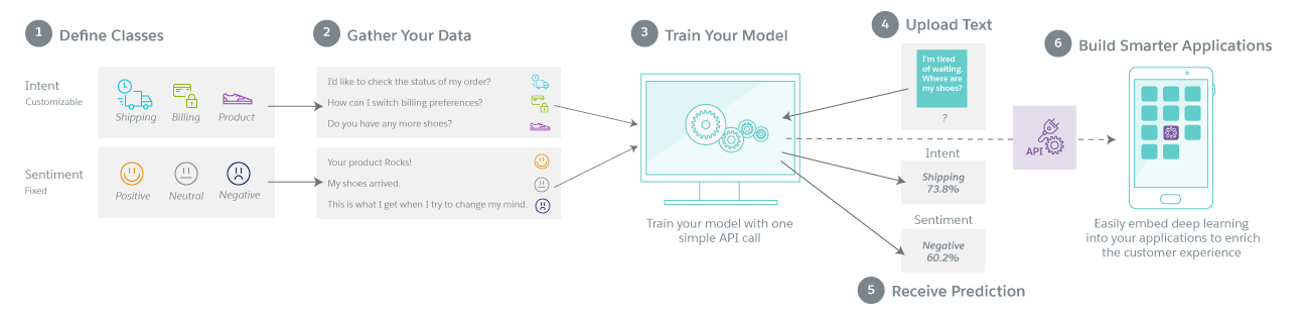

*Example limits: the maximum file size you can upload from a local drive is 25 MB. The maximum number of words per example is 50.*

Recommends that a dataset have a maximum of 500 labels.

See [Create a Dataset from a file](https://metamind.readme.io/docs/create-a-lang-dataset-from-file).

In [178]:
import text_classification_benchmarks.api_services.einstein_service as einstein

In [ ]:
# importlib.reload(einstein)

In [179]:
BASE_EINSTEIN_URL = 'https://api.einstein.ai/v2/language'

In [180]:
USERNAME = os.environ['EINSTEIN_USERNAME']

In [181]:
PEM_FILENAME = os.environ['EINSTEIN_PEM_FILENAME']

In [182]:
MODEL_ID = os.environ['EINSTEIN_MODEL_ID']

In [183]:
einstein_service = einstein.EinsteinService(classes, 
                                            username=USERNAME, 
                                            private_key_pem_filename=PEM_FILENAME, 
                                            model_id=MODEL_ID, 
                                            max_api_calls=max_api_calls, 
                                            verbose=False)

### Generate Access Token

In [ ]:
# access_token = einstein_service.get_access_token()

### Create Training Set

In [ ]:
# TRAINING_DATA_URL = 'https://s3-ap-southeast-2.amazonaws.com/txtclz/case_routing_intent.csv'

In [ ]:
# training_set_filename = einstein.create_dataset(pd.concat([train_df, val_df]))

**Upload training data**

In [ ]:
# !curl -X POST -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" -H "Content-Type: multipart/form-data" -F "data=@$training_set_filename" -F "type=text-intent"  $BASE_EINSTEIN_URL/datasets/upload

In [ ]:
# result = einstein_service.upload_training_data(TRAINING_DATA_URL)
# dataset_id = result['id']

**Get upload status**

In [ ]:
# !curl -X GET -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" $BASE_EINSTEIN_URL/datasets/$dataset_id

In [ ]:
# einstein_service.get_upload_status(dataset_id)

**Train model**

In [ ]:
# !curl -X POST -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" -H "Content-Type: multipart/form-data" -F "name=Case Routing Model" -F "datasetId=$dataset_id" $BASE_EINSTEIN_URL/train

In [ ]:
# result = einstein_service.train_model(dataset_id)
# model_id = result['id']

**Delete model**

In [ ]:
# !curl -X DELETE -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" $BASE_EINSTEIN_URL/models/$model_id

In [ ]:
# einstein_service.delete_model(model_id)

**Get training status**

In [ ]:
# !curl -X GET -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" $BASE_EINSTEIN_URL/train/$model_id

In [ ]:
# einstein_service.get_training_status(model_id)

**Predict Test**

In [ ]:
# sample_utterance = 'What is the customer number?'

In [ ]:
# !curl -X POST -H "Authorization: Bearer $access_token" -H "Cache-Control: no-cache" -H "Content-Type: multipart/form-data" -F "modelId=$model_id" -F "document=$sample_utterance" $BASE_EINSTEIN_URL/intent

In [ ]:
# einstein_service.predict(sample_utterance)

**Get model metrics**

In [ ]:
# metrics = einstein_service.get_metrics(MODEL_ID)
# print('Training accuracy:', metrics['trainingAccuracy'], 'Test accuracy:', metrics['testAccuracy'])

### Call Einstein API Service

In [ ]:
# einstein_service.get_training_status(MODEL_ID)

In [184]:
y_pred = einstein_service.predict_batch(test_df)

Fetching new access token


In [185]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.46
Recall (weighted avg)   : 0.48
F1 Score (weighted avg) : 0.44
Accuracy                : 0.48
ROC AUC (macro avg)     : 0.71


In [186]:
mean_latency = round(einstein_service.mean_latency(), 4)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 1.2323


In [187]:
data = dict({'model': 'Salesforce Einstein', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [188]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


### Notes:

* Signing up for a trial Salesforce account didn't work well - only every third or fourth API call would success; the rest would complain about an "Invalid JWT Token", even though the same token would work next try or two. (Rate limits referred only to number of transactions per month - 2,000.)
* An Heroku account faired much better after some confusion as to difference between "Einstein Platform Services" and "Einstein Vision and Language Services" - use the latter.
* You can define your own hyperparameters, such as number of epochs, learning rate, and validation set split (default 90%).

# Other Models

## fastText

[Bag of Tricks for Efficient Text Classification](https://arxiv.org/pdf/1607.01759.pdf)

NOTE: This method uses fastText's classification model.

Recently, models based on neural networks have become increasingly popular (Kim, 2014; Zhang and LeCun, 2015; Conneau et al., 2016). While these models achieve very good performance in practice, they tend to be relatively slow both at train and test time, limiting their use on very large datasets.

A simple and efficient baseline for sentence classification is to represent sentences as a bag-of-words (BOW) and train a linear classifier, e.g. a logistic regression or an SVM (Joachims, 1998; Fan et al., 2008). However, linear classifiers do not share parameters among features and classes. This possibly limits their generalization in the context of large output space where some classes have very few examples. Common solutions to this problem are to factorize the linear classifier into low rank matrices (Schutze, 1992; Mikolov et al., 2013) or to use multilayer neural networks (Collobert and Weston, 2008; Zhang et al., 2015).

**Hierarchical Softmax**

When the number of classes is large, computing the linear classifier is computationally expensive. More precisely, the computational complexity is `O(kh)` where `k` is the number of classes and `h` the dimension of the text representation. In order to improve our running time, we use a hierarchical softmax (Goodman, 2001) based on the Huffman coding tree (Mikolov et al., 2013). During training, the computational complexity drops to `O(h log2(k))`.

Model architecture of a fastText for a sentence with `N` ngram features `x1, ...xn`. The features are embedded and averaged to calculate the hidden variable.

This architecture is similar to the CBOW model of Mikolov et al. (2013), where the middle word is replaced by a label. We use the softmax function `f` to compute the probability distribution over the predefined classes. Cross entropy is used to compute loss. As a bag-of-words representation does not consider word order, n-gram features are used to capture some partial information about the local word order.

Also see [Releasing fastText](https://fasttext.cc/blog/2016/08/18/blog-post.html).

In [189]:
import fastText as ft

### Bigrams

In [ ]:
# model = ft.load_model('../fasttext/classifier.ftz')

In [ ]:
# y_pred = []
# for i, utterance in enumerate(test_df.utterance.values[:max_api_calls]):
#     label = model.predict(utterance)
#     y_pred.append(classes.tolist().index(label[0][0][9:]))

In [ ]:
# stats = perf_summary(y_test[:max_api_calls], y_pred)
# print_perf_summary(stats, rounded=2)

### Trigrams

In [190]:
model = ft.load_model('../fasttext/classifier.ftz')

In [191]:
y_pred = []
elapsed = []
for i, utterance in enumerate(test_df.utterance.values[:max_api_calls]):
    tic = time.time()
    label = model.predict(utterance)
    toc = time.time()
    elapsed.append(toc - tic)
    y_pred.append(classes.tolist().index(label[0][0][9:]))

In [192]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.7
Recall (weighted avg)   : 0.7
F1 Score (weighted avg) : 0.67
Accuracy                : 0.7
ROC AUC (macro avg)     : 0.85


In [193]:
mean_latency = np.mean(elapsed) if elapsed else 0
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 2.9441118240356445e-05


In [194]:
data = dict({'model': 'fastText Classification', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [195]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


# Deep Learning Models

## Word-level CNN (Kim 2014)

CNNs have become a modern standard baseline method akin to Naive Bayes models, Support Vector Machine (SVMs) and Logistic Regression.

Originally invented for computer vision, CNN models have subsequently been shown to be effective for NLP and have achieved excellent results in semantic parsing (Yih et al., 2014), search query retrieval (Shen et al., 2014), sentence modeling (Kalchbrenner et al., 2014), and other traditional NLP tasks (Collobert et al., 2011).

The first layer embeds words into low-dimensional vectors. The next layer performs convolutions over the embedded word vectors using multiple filter sizes. For example, sliding over 3, 4 or 5 words at a time. Next, we max-pool the result of the convolutional layer into a long feature vector, add dropout regularization, and classify the result using a softmax layer.

See [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf).

In [196]:
from tensorflow.contrib import learn
import text_classification_benchmarks.word_cnn.util as util

In [197]:
checkpoint_dir = '../word_cnn/runs/1540695350/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [198]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [199]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


In [200]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1540695350/checkpoints/model-17800


In [201]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.59
Recall (weighted avg)   : 0.6
F1 Score (weighted avg) : 0.56
Accuracy                : 0.6
ROC AUC (macro avg)     : 0.78


In [202]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0018544256687164306


In [203]:
data = dict({'model': 'Word-level CNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [204]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Word-level CNN initialised with Word2Vec embeddings

Trains the above CNN initialised with word vectors obtained from an unsupervised neural language model. These vectors were trained by Mikolov et al. (2013) on 100 billion words of Google News. The vectors have dimensionality of 300 and were trained using the continuous bag-of-words
architecture.

We keep the word vectors static and learn only the other parameters of the model.

In [205]:
checkpoint_dir = '../word_cnn/runs/1541065783/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [206]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [207]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [208]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541065783/checkpoints/model-17800


In [209]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.57
Recall (weighted avg)   : 0.58
F1 Score (weighted avg) : 0.55
Accuracy                : 0.58
ROC AUC (macro avg)     : 0.78


A little bit better.

See also [A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf).

In [210]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0017267203330993653


In [211]:
data = dict({'model': 'Word-level CNN + Embeddings', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [212]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


### With Embeddings + L2 regularization (l2_reg_lambda = 0.15)

In [213]:
checkpoint_dir = '../word_cnn/runs/1541112212/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [214]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [215]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [216]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541112212/checkpoints/model-8900


In [217]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.62
Recall (weighted avg)   : 0.58
F1 Score (weighted avg) : 0.56
Accuracy                : 0.58
ROC AUC (macro avg)     : 0.79


In [218]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0027205443382263186


In [219]:
data = dict({'model': 'Word-level CNN + Embeddings + L2 Reg', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [220]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


### With Embeddings + higher dropout rate (keep_prob = 0.25)

In [221]:
checkpoint_dir = '../word_cnn/runs/1541241817/checkpoints'
vocab_path = os.path.join(checkpoint_dir, '..', 'vocab')

In [222]:
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

In [223]:
x_raw = test_df.utterance.values[:max_api_calls]
x_test = np.array(list(vocab_processor.transform(x_raw)))

In [224]:
tic = time.time()
y_pred = util.test(x_test, batch_size=64, checkpoint_dir=checkpoint_dir, 
                   allow_soft_placement=True, log_device_placement=False)
toc = time.time()

INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


INFO:tensorflow:Restoring parameters from /Users/d777710/src/DeepLearning/dltemplate/src/text_classification_benchmarks/word_cnn/runs/1541241817/checkpoints/model-8900


In [225]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.6
Recall (weighted avg)   : 0.6
F1 Score (weighted avg) : 0.57
Accuracy                : 0.6
ROC AUC (macro avg)     : 0.78


In [226]:
mean_latency = (toc - tic) / len(x_test)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0017131209373474122


In [227]:
data = dict({'model': 'Word-level CNN + Embeddings + Higher Dropout', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [228]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Character-level CNN (Kim et al. 2015)

[Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

Character-level ConvNet is an effective method for text classification without the need for words.

Historically, ConvNets usually require large-scale datasets to work. In this case, it appears to be competitive on our small dataset.

ConvNets may work well for user-generated data. Further analysis is needed to validate the hypothesis that ConvNets are truly good at identifying exotic character combinations such as misspellings and emoticons.

In [229]:
import text_classification_benchmarks.char_cnn.model_setup as setup
import text_classification_benchmarks.char_cnn.util as util

Using TensorFlow backend.


In [230]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"\/\\|_@#$%^&*~`+-=<>()[]{}"
input_size = 400
n_classes = len(classes)
x_test_cropped = test_df.utterance.values[:max_api_calls]
y_test_cropped = test_df.label.values[:max_api_calls]

In [231]:
test_data = util.Data(x_test_cropped, y_test_cropped, alphabet, input_size, n_classes)
test_data.load_data()
x_test_onehot, y_test_onehot = test_data.get_all_data()

In [232]:
model = setup.CharCNN(input_size,
                      alphabet_size=69,
                      embedding_size=128,
                      conv_layers=[[256, 10], [256, 7], [256, 5], [256, 3]],
                      fully_connected_layers=[1024, 1024],
                      n_classes=n_classes,
                      keep_prob=0.1,
                      model_filename='../char_cnn/models/weights.best.hdf5',
                      optimizer='adam',
                      loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Loading model at ../char_cnn/models/weights.best.hdf5
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sent_input (InputLayer)          (None, 400)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 400, 128)      8960        sent_input[0][0]                 
____________________________________________________________________________________________________
Conv1D_256_10 (Conv1D)           (None, 391, 256)      327936      embedding_1[0][0]                
____________________________________________________________________________________________________
Conv1D_256_7 (Conv1D)            (None, 394, 256)      229632      embedding_1[0][0]                
___________________________________________________________________________________________

In [233]:
tic = time.time()
preds = model.predict(x_test_onehot, batch_size=128)
toc = time.time()

In [234]:
y_pred = np.argmax(preds, axis=1) + 1

In [235]:
stats = perf_summary(y_test[:max_api_calls], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.59
Recall (weighted avg)   : 0.58
F1 Score (weighted avg) : 0.56
Accuracy                : 0.58
ROC AUC (macro avg)     : 0.78


In [236]:
mean_latency = (toc - tic) / len(x_test_cropped)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.005491291284561157


In [237]:
data = dict({'model': 'Char-level CNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [238]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Bidirectional LSTM (Recurrent Neural Network)

In [239]:
import text_classification_benchmarks.bi_lstm.util as util

In [ ]:
# importlib.reload(util)

In [240]:
batch_size = 64
cropped_size = max_api_calls if max_api_calls > batch_size else batch_size
train_labels, train_utterances, train_lengths = util.prepare_data(pd.concat([train_df, val_df]))
test_labels, test_utterances, test_lengths = util.prepare_data(test_df[:cropped_size])
max_length = max(np.concatenate([train_lengths, test_lengths]))

vocab_processor = learn.preprocessing.VocabularyProcessor(max_length, min_frequency=0)
vocab_processor.restore('../bi_lstm/vocab_bal')

x_train_indexed = np.array(list(vocab_processor.transform(train_utterances)))
x_test_indexed = np.array(list(vocab_processor.transform(test_utterances)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


In [241]:
# Training performance
y_pred = util.test(x_train_indexed, train_labels, train_lengths, batch_size=batch_size, 
                   run_dir='../bi_lstm/', checkpoint='clf-8000', model_name='model_bal')

INFO:tensorflow:Restoring parameters from ../bi_lstm/model_bal/clf-8000


INFO:tensorflow:Restoring parameters from ../bi_lstm/model_bal/clf-8000


Test accuracy: 0.9583444151472538


In [242]:
# Test performance
tic = time.time()
y_pred = util.test(x_test_indexed, test_labels, test_lengths, batch_size=batch_size, 
                   run_dir='../bi_lstm/', checkpoint='clf-8000', model_name='model_bal')
toc = time.time()

INFO:tensorflow:Restoring parameters from ../bi_lstm/model_bal/clf-8000


INFO:tensorflow:Restoring parameters from ../bi_lstm/model_bal/clf-8000


Test accuracy: 0.78125


Looks like overfitting. Need a more data!

In [243]:
stats = perf_summary(y_test[:cropped_size], y_pred)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.54
Recall (weighted avg)   : 0.54
F1 Score (weighted avg) : 0.52
Accuracy                : 0.54
ROC AUC (macro avg)     : 0.76


In [244]:
mean_latency = (toc - tic) / len(x_test_indexed)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.004424729347229004


In [245]:
data = dict({'model': 'BiLSTM', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [246]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Combined CNN and RNN

In [247]:
import common.load_data as load_data
import common.util as data_util
import tf_model.text_classifier.util as util

In [ ]:
# importlib.reload(load_data)
# importlib.reload(data_util)
# importlib.reload(util)

In [248]:
constants = {
    'batch_size': 128,
    'keep_prob': 0.5,
    'emb_dim': 300,
    'eval_every': 500,
    'filter_sizes': [3, 4, 5],
    'n_hidden': 300,
    'l2_reg_lambda': 0.0,
    'max_pool_size': 4,
    'non_static': False,
    'n_epochs': 1000,
    'n_filters': 32,
    'learning_rate': 0.001,
    'decay': 0.9
}

In [ ]:
# train_df_ = pd.concat([train_df[['label', 'utterance']], val_df])
# train_df_ = train_df_.reset_index(drop=True)
# x_train_, y_train_, vocab, vocab_inv, df, labels = \
#     load_data.prepare_classification_training_set(train_df_, selected=['label', 'utterance'])

In [ ]:
# trained_dir = util.train(x_train_, y_train_, vocab, vocab_inv, labels, constants)

In [249]:
TRAINED_DIR = './trained_results_1542333262/'

In [250]:
params, words_index, labels, embedding_mat = util.load_trained_params(TRAINED_DIR)
x_test_, y_test_, df = load_data.prepare_classification_test_set(test_df[:max_api_calls], selected=['utterance'],
                                                                 labels=labels)
tic = time.time()
preds, _, _ = util.predict(x_test_, y_test_, df, params, words_index, labels, embedding_mat, TRAINED_DIR)
toc = time.time()

INFO:root:In prediction, reading trained sequence length...
INFO:root:Max sequence length: 62


seq_len: 62
non_static: False
n_hidden: 300
filter_sizes: [3, 4, 5]
n_filters: 32
emb_dim: 300
max_pool_size: 4
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



INFO:tensorflow:Restoring parameters from ./trained_results_1542333262/best_model


INFO:tensorflow:Restoring parameters from ./trained_results_1542333262/best_model
CRITICAL:root:./trained_results_1542333262/best_model has been loaded
CRITICAL:root:Prediction complete! Saved to predicted_results_1542333262/.


In [251]:
stats = perf_summary(y_test[:max_api_calls], preds)
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.26
Recall (weighted avg)   : 0.26
F1 Score (weighted avg) : 0.24
Accuracy                : 0.26
ROC AUC (macro avg)     : 0.62


In [252]:
mean_latency = (toc - tic) / len(x_test_)
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.016160213947296144


In [253]:
data = dict({'model': 'Combined CNN + RNN', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [254]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## Transformer

Based on the paper, [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf).

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations.

In [255]:
import tensorflow as tf
import text_classification_benchmarks.transformer.util as util

In [ ]:
# importlib.reload(util)

In [259]:
tf.reset_default_graph()

In [260]:
tic = time.time()
result, labels = util.predict(test_file='../fasttext/test.txt',
                              n_classes=len(classes),
                              learning_rate=0.01,
                              batch_size=256,
                              decay_steps=12000,
                              decay_rate=1.0,
                              seq_len=60,
                              embed_size=300,
                              d_model=300,
                              d_k=64,
                              d_v=64,
                              h=10,
                              n_layers=1,
                              l2_lambda=0.0001,
                              checkpoint_dir='../transformer/trnfmr_model/',
                              vocab_labels_filename='../transformer/labels.txt',
                              word2vec_filename='../../../data/word2vec/GoogleNews-vectors-negative300.bin'
                             )
toc = time.time()

Transformer Classification Vocab size: 500001
Loading data...
test data length: 703
n_examples: 703
Encoding started
Encoding ended. Q: Tensor("layer_normalization_0_encoder_position_wise_ff/add_1:0", shape=(256, 60, 300), dtype=float32), Ks: Tensor("layer_normalization_0_encoder_position_wise_ff/add_1:0", shape=(256, 60, 300), dtype=float32), latency: 0.16435813903808594
Restoring variables from checkpoint
INFO:tensorflow:Restoring parameters from ../transformer/trnfmr_model/model-17


INFO:tensorflow:Restoring parameters from ../transformer/trnfmr_model/model-17


data length: 703


In [261]:
intents = [x[1][0] for x in result]
preds = [list(classes).index(x) for x in intents]
y_true = [list(classes).index(x) for x in labels]

In [262]:
stats = perf_summary(y_true[:max_api_calls], preds[:max_api_calls])
print_perf_summary(stats, rounded=2)

Precision (weighted avg): 0.32
Recall (weighted avg)   : 0.33
F1 Score (weighted avg) : 0.31
Accuracy                : 0.33
ROC AUC (macro avg)     : 0.64


In [263]:
mean_latency = (toc - tic) / n_test
print('Mean latency (secs):', mean_latency)

Mean latency (secs): 0.0034058077067433516


In [264]:
data = dict({'model': 'Transformer', 'mean_latency': mean_latency}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [265]:
benchmarks

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,Multinomial Naive Bayes,0.222150,0.285,0.207044,0.285,0.588689,0.002400
1,Logistic Regression,0.460985,0.470,0.433593,0.470,0.711460,0.002400
2,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
3,NBSVM,0.559774,0.565,0.529759,0.565,0.757527,0.346400
4,RASA NLU Spacy-sklearn,0.200194,0.270,0.209956,0.270,0.603433,0.013600
5,RASA NLU TensorFlow,0.584003,0.565,0.538373,0.565,0.765673,0.001400
6,Snips NLU,0.588833,0.500,0.494917,0.500,0.779493,0.011600
7,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
8,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
9,Microsoft LUIS,0.494847,0.470,0.447800,0.470,0.712523,0.697800


## AutoML

### Google AutoML Natural Language

Not enough training examples.

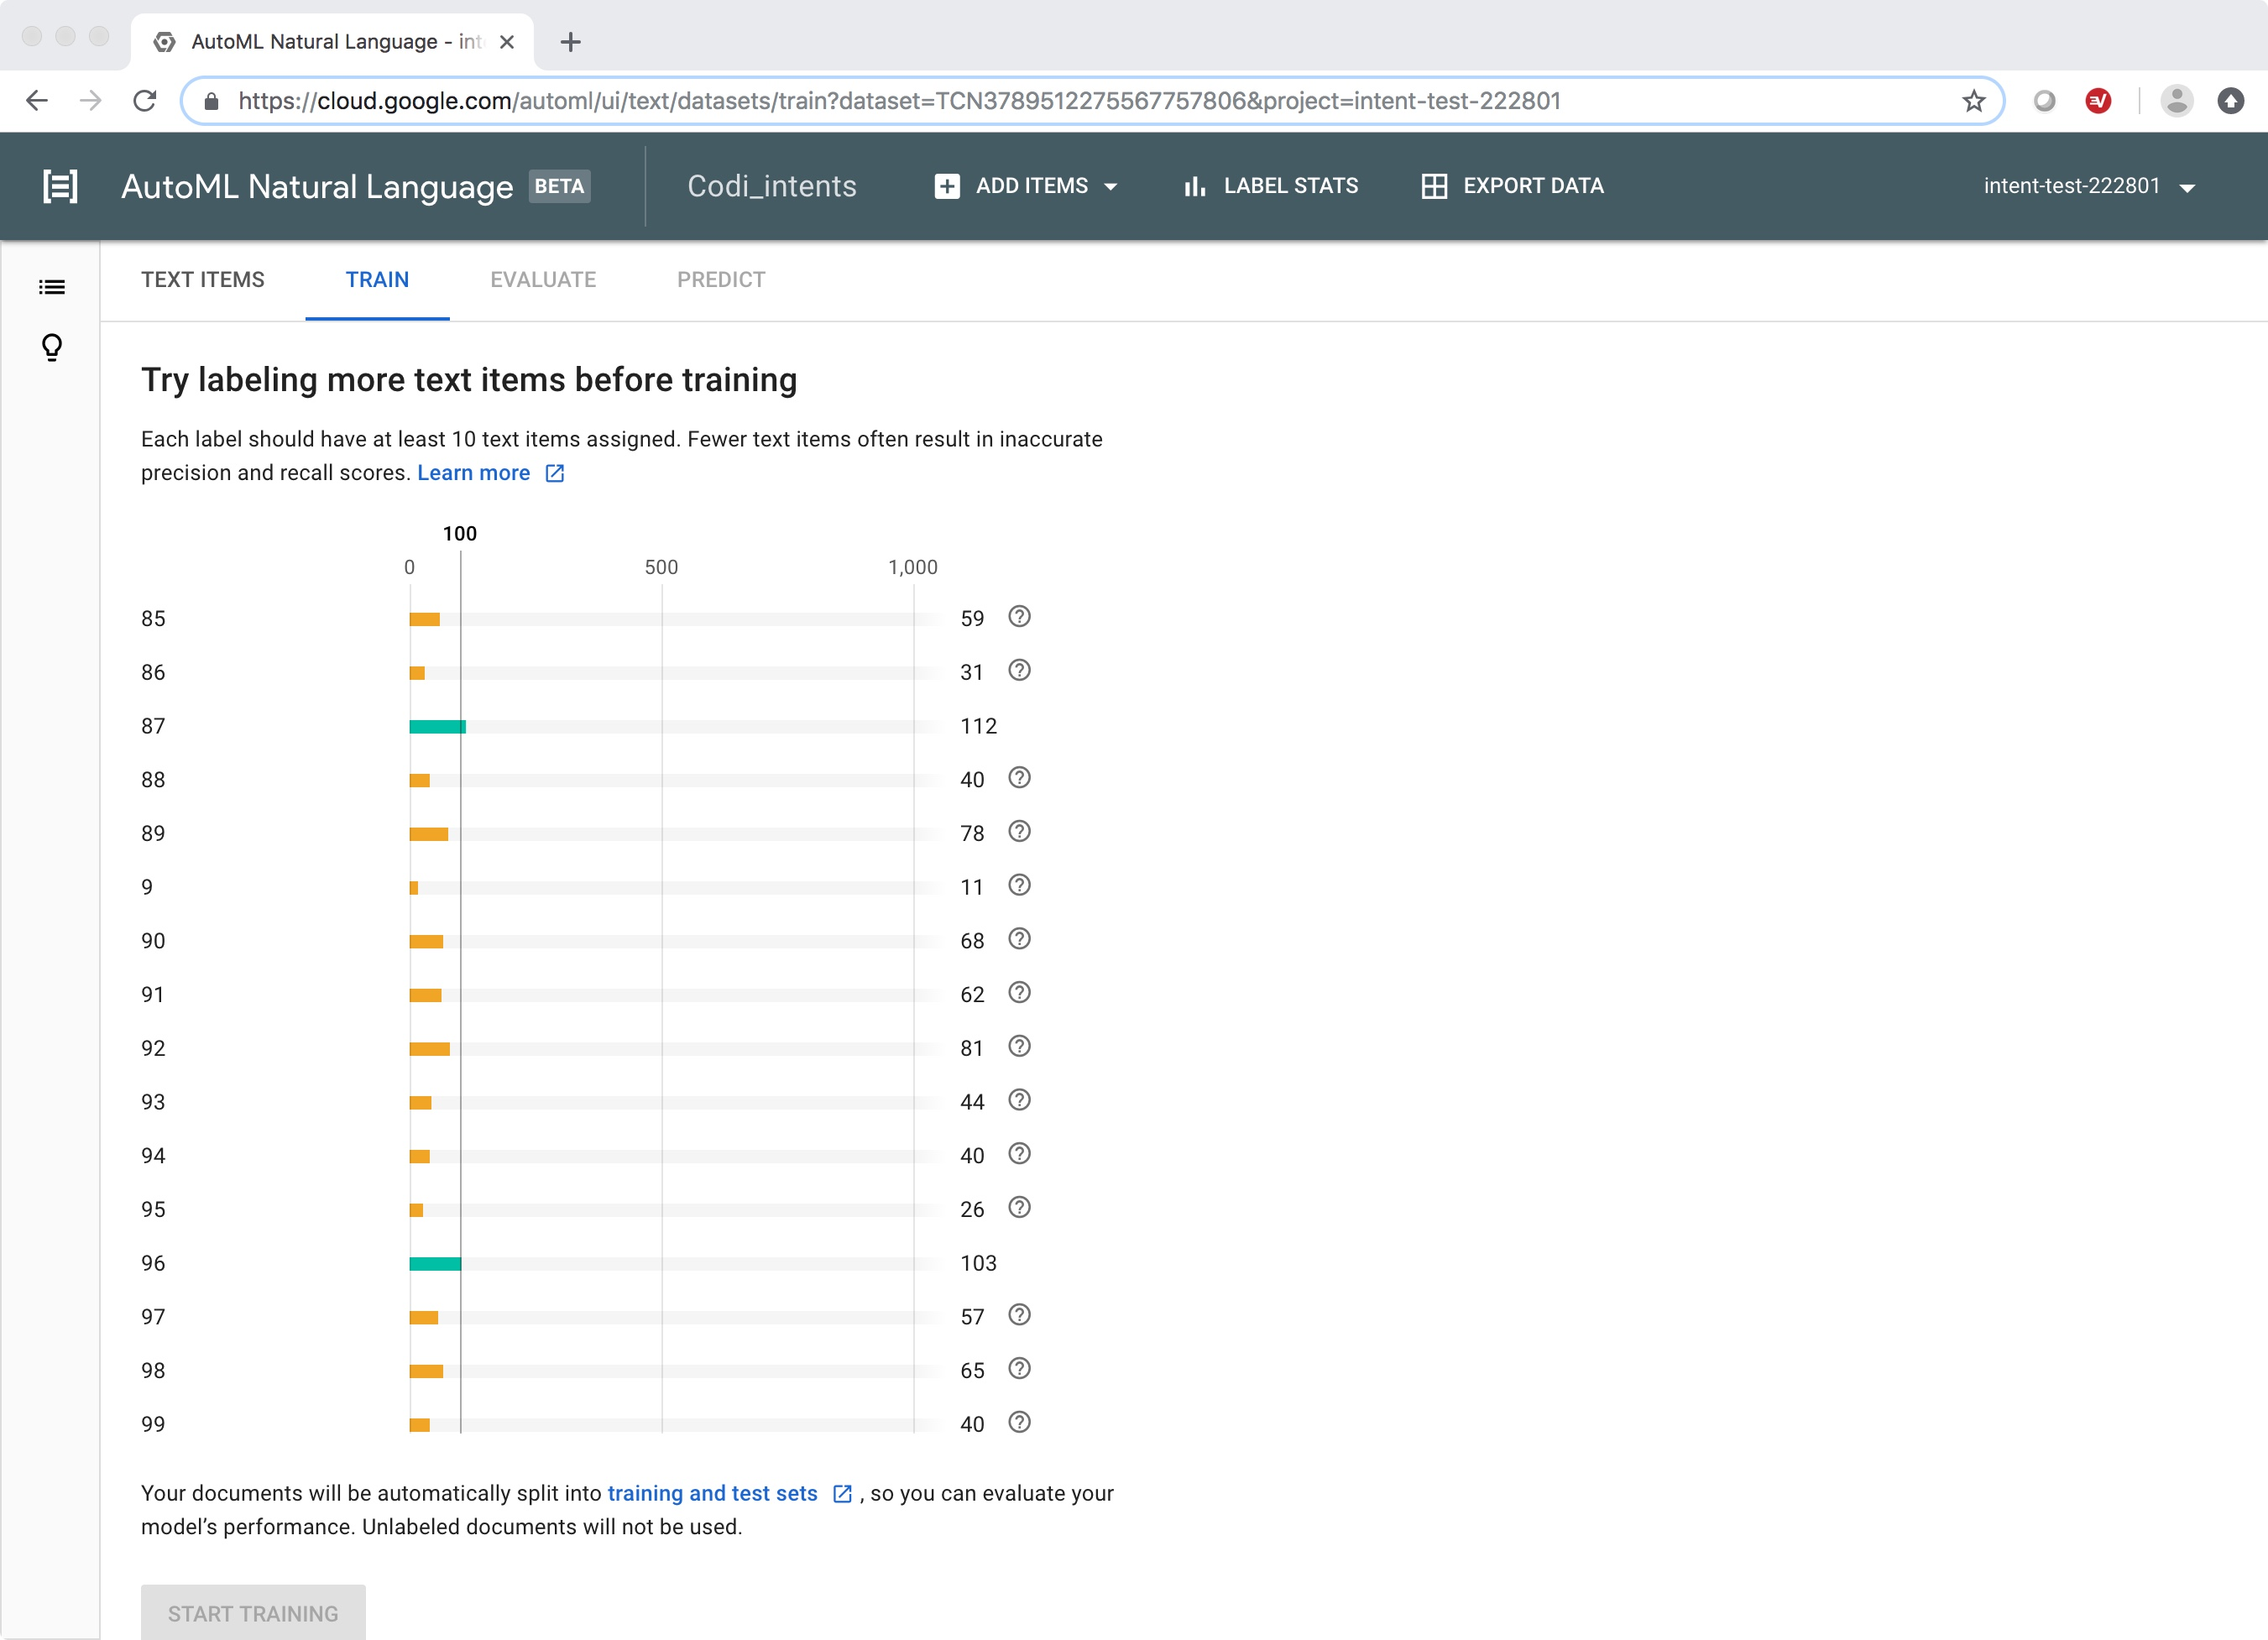

In one example, we are seeing 3.5 hours training spent for a public Kaggle dataset HappyDB, which contains about 12,000 items.

## BERT

See [BERT Notebook](./BERT.ipynb).

In [266]:
stats = {
    'precision_weighted_avg': 0.77,
    'recall_weighted_avg': 0.75,
    'f1_weighted_avg': 0.73,
    'accuracy': 0.75,
    'roc_auc': 0.88
}

In [272]:
data = dict({'model': 'BERT', 'mean_latency': -1}, **stats)
benchmarks = benchmarks.append(data, ignore_index=True)

In [ ]:
# benchmarks.at[21, 'mean_latency'] = 0

# Overall Rankings

In [273]:
ranked = benchmarks.sort_values(['f1_weighted_avg', 'mean_latency'], ascending=[False, True])
ranked.reset_index(drop=True)

,model,precision_weighted_avg,recall_weighted_avg,f1_weighted_avg,accuracy,roc_auc,mean_latency
0,BERT,0.770000,0.750,0.730000,0.750,0.880000,-1.000000
1,fastText Classification,0.695417,0.695,0.669802,0.695,0.853570,0.000029
2,IBM Watson,0.676226,0.665,0.644895,0.665,0.828074,0.269600
3,Google Dialogflow,0.666929,0.665,0.634138,0.665,0.814926,0.679500
4,Word-level CNN + Embeddings + Higher Dropout,0.600994,0.600,0.573093,0.600,0.784758,0.001713
5,Word-level CNN + Embeddings + L2 Reg,0.623262,0.585,0.562414,0.585,0.790105,0.002721
6,Linear SVC,0.593718,0.575,0.560262,0.575,0.766103,0.000009
7,Word-level CNN,0.585286,0.595,0.558797,0.595,0.775870,0.001854
8,Char-level CNN,0.594917,0.585,0.555452,0.585,0.783413,0.005491
9,Word-level CNN + Embeddings,0.572095,0.580,0.546956,0.580,0.778570,0.001727


In [ ]:
ranked.to_csv('ranked.csv', header=True, index=False)

## Notes

### Approaches

Conventional:
* SVM for domain/intent classification
* CRF for slot filling

Deep learning:
* LSTM for domain/intent classification and slot filling

According to literature search, Multinominal Naive Bayes is better at snippets. MNB is normally better and more stable than multivariate Bernoulli NB, and binarized MNB is better than standard MNB. Whereas, SVM is better at full-length reviews. The results above seem to be an exception to these rules-of-thumb.

NBSVM: a simple but novel SVM variant using NB log-count ratios as feature values consistently performs well across tasks and datasets.

[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](http://www.aclweb.org/anthology/P12-2018)

Dataset size forms a dichotomy between traditional and ConvNets models. The most obvious trend is that the larger datasets tend to perform better. Traditional methods like n-grams TFIDF remain strong candidates for datasets of size up to several hundreds of thousands, and only until the dataset goes to the scale of several millions do we observe that character-level ConvNets start to do better.

### API Observations

* IBM API straightforward
* Google documentation could be better, e.g. session ID as hard-coded value not mentioned, API formats not documented: had to refer to export as sample
* Microsoft - complex setup: need to assign resource groups from Azure, lacking error details on JSON response: unhelpful messages such as "Bad Format" for a large JSON input, annoying limits such as 50 char limit on intent names and utterance text. (Max limits on number of intents, etc. have been increased from earlier release.)
* Amazon Lex - The number of intents exceeds the permissible value. A bot can have a maximum of 100 intents. This bot has 182. Slow import process. Intent names only alpha + underscores. Utterance length limited to 200. Issues with a few duplicate utterances. Build failed: "The rate of requests exceeds the throughput limit. Retry the request." UI update issues on latest Chrome. Some save operations strangely slow. Doesn't accept numbers. "An utterance can consist only of Unicode characters, spaces, and valid punctuation marks. Valid punctuation marks are: periods for abbreviations, underscores, apostrophes, and hyphens." However, doesn't accept examples with underscores or apostrophes!

### TODO

1. Stratified sampling for splits
2. Preprocessing the data for fastText
3. Data augmentation?